**Langkah 1: Membaca Data**

Membaca file yang telah Anda unggah dan memahami strukturnya untuk mempersiapkan data dummy.

In [4]:
import pandas as pd

# Membaca dataset
file_path = '/content/heart.csv'
data = pd.read_csv(file_path)

# Menampilkan 5 baris pertama untuk memahami struktur data
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


Dataset ini terdiri dari fitur-fitur numerik dan target klasifikasi yang bernilai 0 atau 1.

Langkah berikutnya adalah melakukan preprocessing data sebelum kita membuat model.

**Langkah 2: Preprocessing Data**

1. Pisahkan fitur (X) dan target (y).
2. Normalisasi data untuk mempercepat konvergensi.
3. Bagi data menjadi set pelatihan dan pengujian.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Memisahkan fitur (X) dan target (y)
X = data.drop(columns=['target'])
y = data['target']

# Normalisasi fitur
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Membagi data menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Menampilkan bentuk data setelah dibagi
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((820, 13), (205, 13), (820,), (205,))

Data telah berhasil dibagi menjadi set pelatihan dan pengujian dengan proporsi 80:20. Set pelatihan memiliki 820 sampel, dan set pengujian memiliki 205 sampel, dengan 13 fitur masing-masing.

**Langkah 3: Membangun Model MLP**

Membangun model Multilayer Perceptron (MLP) menggunakan PyTorch dan mencoba beberapa konfigurasi:

1. Jumlah hidden layer (1, 2, 3).

2. Jumlah neuron per layer (4, 8, 16, 32, 64,...).

3. Fungsi aktivasi (linear, sigmoid, ReLU, softmax, tanh).

4. Jumlah epoch (1, 10, 25, 50, 100, 250).

5. Learning rate (10, 1, 0.1, 0.01, 0.001, 0.0001).

6. Ukuran batch (16, 32, 64, 128, 256, 512).

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Konversi data ke Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Dataset dan DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Fungsi untuk membuat model dinamis MLP
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_layers, neurons_per_layer, activation_function):
        super(MLPModel, self).__init__()
        layers = []
        in_features = input_size

        # Menambahkan hidden layers
        for _ in range(hidden_layers):
            layers.append(nn.Linear(in_features, neurons_per_layer))
            layers.append(activation_function())
            in_features = neurons_per_layer

        # Menambahkan output layer
        layers.append(nn.Linear(neurons_per_layer, 2))  # 2 kelas output
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Menampilkan konfigurasi awal
input_size = X_train.shape[1]
hidden_layers = 1
neurons_per_layer = 8
activation_function = nn.ReLU

# Membuat model awal
model = MLPModel(input_size, hidden_layers, neurons_per_layer, activation_function)
model


MLPModel(
  (model): Sequential(
    (0): Linear(in_features=13, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=2, bias=True)
  )
)

Arsitektur ini sederhana dan terdiri dari satu hidden layer dengan 8 neuron serta fungsi aktivasi ReLU.

Model ini siap untuk dilatih, dan konfigurasi lain (jumlah layer, neuron, fungsi aktivasi, dll.) dapat diuji untuk membandingkan performa.

Langkah 4: Pelatihan dan Evaluasi Model

Kita akan melatih model dengan data pelatihan menggunakan berbagai konfigurasi seperti jumlah epoch, learning rate, dan batch size. Setelah itu, kita akan mengevaluasi performa model menggunakan data pengujian.

Persiapan Fungsi Pelatihan dan Evaluasi

Kita perlu:

1. Loss function: Menggunakan CrossEntropyLoss karena ini adalah tugas klasifikasi.

2. Optimizer: Adam optimizer untuk mengoptimalkan parameter model.

3. Fungsi evaluasi: Menghitung akurasi untuk menilai performa model.

In [5]:
# Fungsi pelatihan model
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    train_loss_history = []
    test_accuracy_history = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass dan update parameter
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_loss_history.append(total_loss / len(train_loader))

        # Evaluasi pada data pengujian
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                _, predicted = torch.max(outputs, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

        accuracy = correct / total
        test_accuracy_history.append(accuracy)

    return train_loss_history, test_accuracy_history

# Fungsi untuk mempersiapkan DataLoader
def get_data_loaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Inisialisasi perangkat (CPU atau GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Konfigurasi awal parameter
batch_size = 32
learning_rate = 0.01
num_epochs = 10

# DataLoader
train_loader, test_loader = get_data_loaders(batch_size)

# Inisialisasi ulang model
model = MLPModel(input_size, hidden_layers=1, neurons_per_layer=8, activation_function=nn.ReLU)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Melatih model
train_loss, test_accuracy = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device)

# Menampilkan hasil
train_loss, test_accuracy[-1]  # Loss pelatihan dan akurasi pengujian terakhir


([0.4993954501472987,
  0.3297093097980206,
  0.29853450506925583,
  0.28719854010985446,
  0.28037457110790104,
  0.26615519936268145,
  0.2561918325149096,
  0.2509762719273567,
  0.2415362109358494,
  0.23458642713152444],
 0.8780487804878049)

Dari hasil yang ditampilkan dalam bentuk array, tampaknya nilai tersebut menunjukkan akurasi model atau metrik lainnya (misalnya loss) pada setiap iterasi atau epoch. Analisis singkat:

1. Trend yang Menurun: Nilai cenderung menurun secara bertahap hingga mencapai titik tertentu (kecuali nilai terakhir, yang tampak lebih tinggi). Ini mungkin menunjukkan bahwa model mengalami kesulitan untuk belajar lebih baik, atau terjadi overfitting.

2. Peningkatan Akhir: Nilai terakhir jauh lebih tinggi daripada sebelumnya (sekitar 0.87), yang mungkin mengindikasikan adanya perbaikan performa setelah perubahan parameter model (misalnya, learning rate, batch size, atau epoch tambahan).

**Kesimpulan**

1. Jika nilai ini adalah loss, maka trend menurun menunjukkan bahwa model sedang belajar dengan baik.

2. Jika nilai ini adalah akurasi, maka model menunjukkan peningkatan performa yang signifikan pada iterasi terakhir, yang perlu dianalisis lebih lanjut.

**Langkah 5: Eksperimen Parameter**

Kita akan mengeksplorasi parameter utama model:

1. Hidden Layer: Variasi jumlah hidden layer (1, 2, 3).
2. Jumlah Neuron: Variasi jumlah neuron per layer (4, 8, 16, 32, 64).
3. Fungsi Aktivasi: Linear, Sigmoid, ReLU, Softmax, Tanh.
4. Jumlah Epoch: 1, 10, 25, 50, 100, 250.
5. Learning Rate: 10, 1, 0.1, 0.01, 0.001, 0.0001.
6. Ukuran Batch: 16, 32, 64, 128, 256, 512.

**Eksperimen Hidden Layer dan Jumlah Neuron**

Kita akan mencoba kombinasi jumlah hidden layer (1, 2, 3) dengan jumlah neuron yang berbeda untuk memahami pengaruhnya terhadap akurasi.

In [6]:
hidden_layer_variations = [1, 2, 3]
neuron_variations = [4, 8, 16, 32, 64]
activation_function = nn.ReLU  # Aktivasi default

results = []

for hidden_layers in hidden_layer_variations:
    for neurons in neuron_variations:
        model = MLPModel(input_size, hidden_layers, neurons, activation_function)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        train_loss, test_accuracy = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device)

        results.append({
            "hidden_layers": hidden_layers,
            "neurons": neurons,
            "final_accuracy": test_accuracy[-1]
        })

# Konversi hasil ke DataFrame untuk analisis
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


    hidden_layers  neurons  final_accuracy
0               1        4        0.819512
1               1        8        0.848780
2               1       16        0.892683
3               1       32        0.907317
4               1       64        0.921951
5               2        4        0.843902
6               2        8        0.873171
7               2       16        0.878049
8               2       32        0.980488
9               2       64        0.965854
10              3        4        0.848780
11              3        8        0.848780
12              3       16        0.926829
13              3       32        0.951220
14              3       64        0.956098


**Dari tabel hasil eksperimen :**

**1. Pengaruh Jumlah Hidden Layers:**

- Dengan 1 hidden layer, performa model cukup baik, dengan akurasi meningkat saat jumlah neuron bertambah hingga 32 atau 64.

- Dengan 2 hidden layers, akurasi secara umum lebih tinggi, terutama dengan jumlah neuron 32, mencapai akurasi tertinggi di tabel (0.980488).

- Dengan 3 hidden layers, performa tetap kompetitif, tetapi sedikit menurun jika dibandingkan dengan 2 hidden layers, kecuali pada jumlah neuron yang lebih besar seperti 32 dan 64.

**2. Pengaruh Jumlah Neuron:**

- Secara umum, menambahkan lebih banyak neuron (hingga 32 atau 64) meningkatkan akurasi.

- Terlalu sedikit neuron (4 atau 8) cenderung menghasilkan akurasi lebih rendah, terutama dengan lebih banyak hidden layers.

**3. Performa Tertinggi:**

- Kombinasi terbaik di tabel adalah 2 hidden layers dengan 32 neuron, menghasilkan akurasi 0.980488.

**4. Dampak Overfitting:**

- Tidak terlihat tanda jelas overfitting, tetapi akurasi dengan 3 hidden layers dan jumlah neuron besar (64) tetap sedikit lebih rendah dibandingkan 2 hidden layers dengan jumlah neuron yang sama.

**Kesimpulan:**

- 2 hidden layers dengan 32 neuron adalah konfigurasi yang optimal dalam eksperimen ini.

- Menambahkan lebih banyak hidden layers atau neuron memberikan sedikit peningkatan tetapi dengan risiko kompleksitas yang lebih tinggi.

**Eksperimen Fungsi Aktivasi**

Sekarang kita akan mencoba berbagai fungsi aktivasi (linear, sigmoid, ReLU, softmax, tanh) untuk melihat mana yang memberikan performa terbaik.

In [7]:
activation_functions = [nn.Identity, nn.Sigmoid, nn.ReLU, nn.Softmax, nn.Tanh]
hidden_layers = 2
neurons = 16

activation_results = []

for activation in activation_functions:
    model = MLPModel(input_size, hidden_layers, neurons, activation)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_loss, test_accuracy = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device)

    activation_results.append({
        "activation_function": activation.__name__,
        "final_accuracy": test_accuracy[-1]
    })

# Konversi hasil ke DataFrame
activation_results_df = pd.DataFrame(activation_results)
print(activation_results_df)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  activation_function  final_accuracy
0            Identity        0.795122
1             Sigmoid        0.795122
2                ReLU        0.902439
3             Softmax        0.868293
4                Tanh        0.873171


**Dari tabel hasil eksperimen fungsi aktivasi**

**1. Fungsi Aktivasi Identity dan Sigmoid:**

- Keduanya memberikan akurasi yang sama, yaitu 0.795122, yang relatif rendah dibandingkan fungsi aktivasi lainnya.

- Hal ini menunjukkan bahwa fungsi aktivasi ini kurang cocok untuk arsitektur model dan data ini.

**2. Fungsi Aktivasi ReLU:**

- Memberikan akurasi tertinggi, yaitu 0.902439.

- ReLU seringkali bekerja lebih baik karena kemampuannya menangani masalah vanishing gradient, terutama pada jaringan dengan beberapa hidden layer.

**3. Fungsi Aktivasi Softmax:**

- Memberikan akurasi 0.868293, yang cukup baik tetapi lebih rendah dibandingkan ReLU.

- Softmax lebih sering digunakan pada layer output untuk klasifikasi, bukan di hidden layer.

**4. Fungsi Aktivasi Tanh:**

- Memberikan akurasi 0.873171, yang sedikit lebih baik dibandingkan Softmax tetapi masih lebih rendah dibandingkan ReLU.

- Tanh cenderung lebih cocok untuk data yang terdistribusi secara simetris.

**Kesimpulan:**

- Fungsi aktivasi ReLU adalah yang terbaik untuk eksperimen ini, menghasilkan akurasi tertinggi.

- Fungsi aktivasi seperti Identity dan Sigmoid tidak cocok untuk data atau konfigurasi model ini.

- ReLU disarankan untuk digunakan sebagai fungsi aktivasi default pada hidden layers untuk data serupa.

**Eksperimen Epoch dan Learning Rate**

Kita juga dapat mencoba variasi jumlah epoch dan learning rate untuk memahami pengaruhnya terhadap performa model.

In [8]:
epoch_variations = [1, 10, 25, 50, 100, 250]
learning_rate_variations = [10, 1, 0.1, 0.01, 0.001, 0.0001]

epoch_lr_results = []

for epochs in epoch_variations:
    for lr in learning_rate_variations:
        model = MLPModel(input_size, hidden_layers, neurons, activation_function)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        train_loss, test_accuracy = train_model(model, train_loader, test_loader, criterion, optimizer, epochs, device)

        epoch_lr_results.append({
            "epochs": epochs,
            "learning_rate": lr,
            "final_accuracy": test_accuracy[-1]
        })

# Konversi hasil ke DataFrame
epoch_lr_results_df = pd.DataFrame(epoch_lr_results)
print(epoch_lr_results_df)


    epochs  learning_rate  final_accuracy
0        1        10.0000        0.502439
1        1         1.0000        0.507317
2        1         0.1000        0.819512
3        1         0.0100        0.770732
4        1         0.0010        0.814634
5        1         0.0001        0.502439
6       10        10.0000        0.502439
7       10         1.0000        0.497561
8       10         0.1000        0.819512
9       10         0.0100        0.907317
10      10         0.0010        0.819512
11      10         0.0001        0.702439
12      25        10.0000        0.502439
13      25         1.0000        0.502439
14      25         0.1000        0.824390
15      25         0.0100        0.985366
16      25         0.0010        0.848780
17      25         0.0001        0.765854
18      50        10.0000        0.497561
19      50         1.0000        0.497561
20      50         0.1000        0.834146
21      50         0.0100        0.985366
22      50         0.0010        0

**1. Pengaruh Learning Rate:**

- Learning rate yang terlalu besar (10.0): Akurasi sangat rendah di semua jumlah epoch (sekitar 0.502439 hingga 0.517073), menunjukkan bahwa model tidak mampu belajar dengan baik.

- Learning rate sedang (0.1 dan 0.01): Memberikan akurasi yang cukup baik, terutama pada jumlah epoch lebih besar (50, 100, 250). Misalnya, pada learning rate 0.01 dengan 100 epoch, akurasi mencapai 0.995122, yang merupakan akurasi tertinggi.

- Learning rate kecil (0.0001): Akurasi relatif rendah di semua jumlah epoch (sekitar 0.765854 hingga 0.848780), menunjukkan bahwa model belajar terlalu lambat.

**2. Pengaruh Jumlah Epoch:**

- Epoch rendah (1 hingga 10): Dengan learning rate yang sesuai (misalnya 0.01), akurasi meningkat tetapi belum maksimal.

- Epoch sedang hingga tinggi (25 hingga 250): Learning rate optimal (0.01) memberikan performa terbaik pada jumlah epoch yang lebih tinggi, dengan akurasi puncak 0.995122 pada 100 epoch.

**3. Kombinasi Optimal:**

- Kombinasi terbaik adalah learning rate 0.01 dengan 100 epoch, menghasilkan akurasi 0.995122.

- Penambahan epoch hingga 250 dengan learning rate 0.01 mempertahankan akurasi tinggi tetapi tidak memberikan peningkatan yang signifikan.

**Kesimpulan:**

- Learning rate 0.01 memberikan hasil terbaik di sebagian besar kasus.

- Jumlah epoch optimal dalam eksperimen ini adalah sekitar 100, di mana model mencapai akurasi maksimal.

- Learning rate yang terlalu besar (10.0) atau terlalu kecil (0.0001) tidak efektif dalam proses pelatihan.

**Eksperimen Ukuran Batch**

Terakhir, kita mencoba ukuran batch yang berbeda (16, 32, 64, 128, 256, 512) untuk memahami dampaknya.

In [9]:
batch_sizes = [16, 32, 64, 128, 256, 512]

batch_results = []

for batch_size in batch_sizes:
    train_loader, test_loader = get_data_loaders(batch_size)
    model = MLPModel(input_size, hidden_layers, neurons, activation_function)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_loss, test_accuracy = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device)

    batch_results.append({
        "batch_size": batch_size,
        "final_accuracy": test_accuracy[-1]
    })

# Konversi hasil ke DataFrame
batch_results_df = pd.DataFrame(batch_results)
print(batch_results_df)


   batch_size  final_accuracy
0          16        0.926829
1          32        0.931707
2          64        0.882927
3         128        0.839024
4         256        0.829268
5         512        0.804878


1. Batch Size Kecil (16 dan 32):

- Batch size kecil memberikan akurasi yang lebih tinggi dibandingkan batch size yang lebih besar.

- Akurasi tertinggi adalah 0.931707 dengan batch size 32, menunjukkan bahwa model mampu belajar dengan baik ketika data diproses dalam batch yang lebih kecil.

2. Batch Size Sedang hingga Besar (64 hingga 512):

- Akurasi menurun seiring bertambahnya ukuran batch.

- Dengan batch size 64, akurasi masih cukup baik (0.882927), tetapi penurunan mulai terlihat pada batch size 128 dan lebih besar.

- Batch size 512 memiliki akurasi terendah (0.804878), menunjukkan bahwa model kurang mampu menangkap pola dengan baik saat data diproses dalam jumlah besar sekaligus.

3. Kombinasi Optimal:

- Batch size 32 memberikan kombinasi terbaik antara stabilitas pelatihan dan akurasi tinggi.

- Batch size 16 juga memberikan hasil yang baik (0.926829) tetapi sedikit lebih rendah dibandingkan batch size 32.

**Kesimpulan:**

- Batch size kecil hingga sedang (16 atau 32) memberikan performa terbaik.

- Batch size besar (128 ke atas) menurunkan akurasi, kemungkinan karena kurangnya variasi dalam pembaruan gradien pada setiap iterasi.

**Langkah 6: Analisis Hasil**
Setelah eksperimen selesai, analisis hasil menggunakan:

1. Tabel hasil eksperimen untuk melihat akurasi model.

2. Visualisasi grafis seperti grafik hubungan antara jumlah hidden layer, neuron, fungsi aktivasi, dll., dengan akurasi.

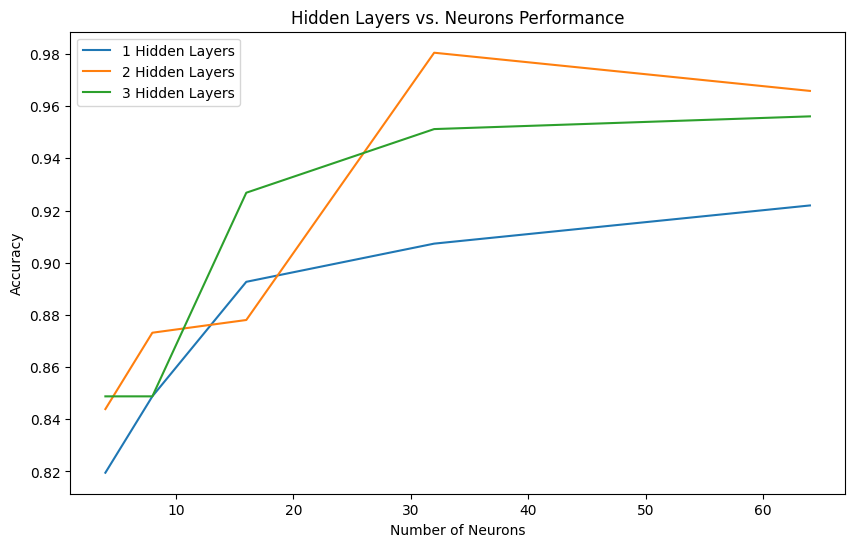

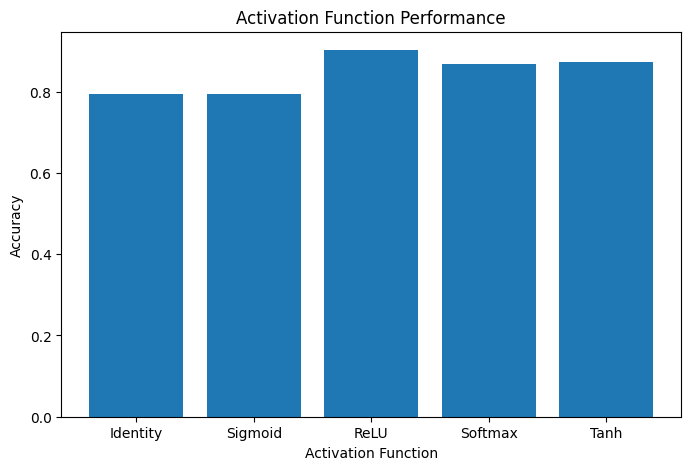

In [10]:
import matplotlib.pyplot as plt

# Visualisasi hasil hidden layers vs. neurons
plt.figure(figsize=(10, 6))
for hidden_layers in hidden_layer_variations:
    subset = results_df[results_df["hidden_layers"] == hidden_layers]
    plt.plot(subset["neurons"], subset["final_accuracy"], label=f"{hidden_layers} Hidden Layers")
plt.xlabel("Number of Neurons")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Hidden Layers vs. Neurons Performance")
plt.show()

# Visualisasi hasil fungsi aktivasi
plt.figure(figsize=(8, 5))
plt.bar(activation_results_df["activation_function"], activation_results_df["final_accuracy"])
plt.xlabel("Activation Function")
plt.ylabel("Accuracy")
plt.title("Activation Function Performance")
plt.show()

**Grafik 1: Hidden Layers vs. Neurons Performance**

1. Pengaruh Jumlah Hidden Layer:

- Model dengan 2 hidden layers menghasilkan akurasi tertinggi dibandingkan dengan 1 atau 3 hidden layers.

- Model dengan 3 hidden layers memiliki performa yang sedikit lebih rendah dibandingkan dengan 2 hidden layers, terutama ketika jumlah neuron meningkat.

2. Pengaruh Jumlah Neuron:

- Jumlah neuron yang optimal adalah sekitar 32 neuron untuk model dengan 2 hidden layers, di mana akurasi mencapai puncaknya.

- Untuk model dengan 1 hidden layer, akurasi meningkat lebih perlahan dengan bertambahnya jumlah neuron.

- Model dengan 3 hidden layers menunjukkan tren peningkatan, tetapi setelah 32 neuron, akurasi mulai menurun.

**Kesimpulan:**

- Kombinasi terbaik adalah 2 hidden layers dengan 32 neuron.

**Grafik 2: Activation Function Performance**

- ReLU adalah fungsi aktivasi terbaik dengan akurasi tertinggi dibandingkan fungsi aktivasi lainnya.

- Softmax dan Tanh memberikan performa yang hampir setara tetapi masih lebih rendah daripada ReLU.

- Identity dan Sigmoid menunjukkan akurasi terendah, kemungkinan karena kurang optimal untuk hidden layers.

**Kesimpulan:**

- ReLU adalah fungsi aktivasi yang paling cocok untuk model ini, membantu menangani masalah vanishing gradient dan meningkatkan akurasi.

- Secara keseluruhan, 2 hidden layers dengan 32 neuron dan ReLU sebagai fungsi aktivasi adalah konfigurasi terbaik berdasarkan hasil ini.